# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in the [multiple linear regression demo](./glucose.ipynb), you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html).  As part of the project, they have created an excellent public dataset: [MERIt](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="http://www.rst.e-technik.tu-dortmund.de/cms/Medienpool/redaktionelleBilder/Forschung/Schwerpunkte/TUDOR_engl/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the data.  Use the `index_col` option to specify that column 0 (the one with time) is the *index* column.  You can review [simple linear regression demo](simp_lin_reg\auto_mpg.ipynb) for examples of using the `pd.read_csv` command.

In [2]:
names =[
    't',                                  # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
] 
df = pd.read_csv('exp1.csv', index_col=0, names=names)

Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [3]:
df.head(6)

,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
t,,,,,,,,,,,,,,,,
0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.  

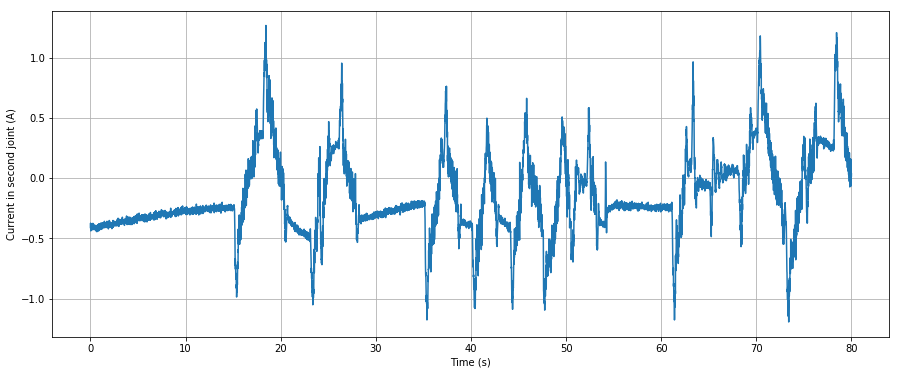

In [4]:
y = df.I2.values
t = df.index.values
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Current in second joint (A)')
plt.grid()
plt.show()

Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [5]:
ytrain = df.I2.values
Xtrain = df[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']].values

## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`.

In [6]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

Train the model on the training data using the `regr.fit(...)` method.

In [7]:
regr.fit(Xtrain, ytrain)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Plot the predicted and actual current `I2` over time on the same plot.  Create a legend for the plot.

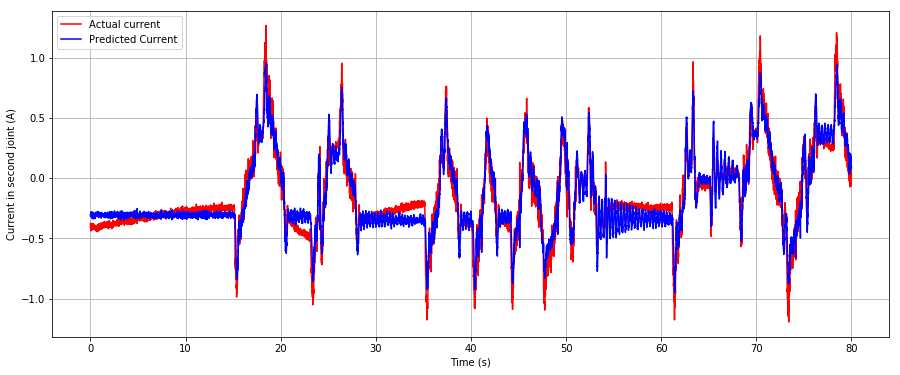

In [8]:
ytrain_pred = regr.predict(Xtrain)
plt.plot(t, ytrain, 'r', label='Actual current')
plt.plot(t, ytrain_pred, 'b', label='Predicted Current')
plt.xlabel('Time (s)')
plt.ylabel('Current in second joint (A)')
plt.legend()
plt.grid()
plt.show()

Measure the normalized RSS given by 
$$
    \frac{RSS}{n s^2_y}.
$$

In [9]:
RSS_train = np.mean((ytrain_pred - ytrain) ** 2) / (np.std(ytrain) ** 2)

## Measure the Fit on an Indepdent Dataset

Load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

In [10]:
df2 = pd.read_csv('exp2.csv', index_col=0, names=names)
ytest = df2['I2'].values
Xtest = df2[['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']].values

Measure the normalized RSS on the test data.  Is it substantially higher than the training data?

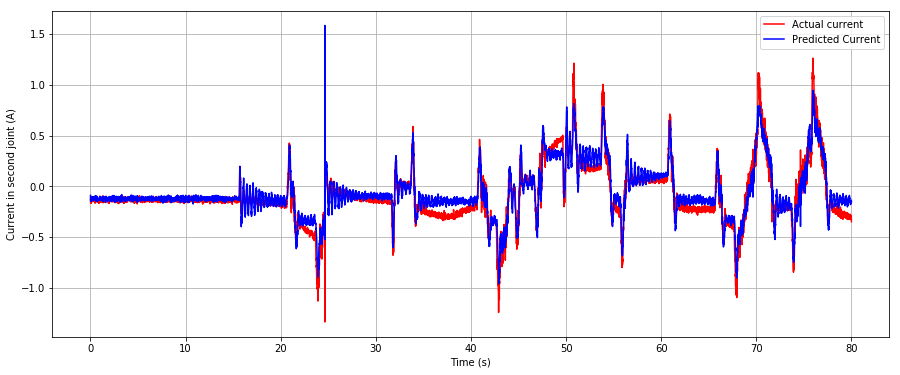

In [11]:
ytest_pred = regr.predict(Xtest)
plt.plot(t, ytest, 'r', label='Actual current')
plt.plot(t, ytest_pred, 'b', label='Predicted Current')
plt.xlabel('Time (s)')
plt.ylabel('Current in second joint (A)')
plt.legend()
plt.grid()
plt.show()

In [12]:
RSS_test = np.mean((ytest_pred - ytest) ** 2) / (np.std(ytest) ** 2)

In [13]:
print('Train RSS = ' , RSS_train)
print('Test RSS = ', RSS_test)

Train RSS =  0.0958326386123
Test RSS =  0.126780488048


##### We can see that the Test RSS is higher than Train RSS